<a href="https://colab.research.google.com/github/db030220/Plogging/blob/main/trashmodel%EC%99%84%EC%84%B12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [27]:
import cv2

cap = cv2.VideoCapture(0)  # 웹캠에서 비디오 캡처 객체 생성
ret, frame = cap.read()   # 캡처된 프레임 읽기

if ret:  # 프레임이 정상적으로 읽어졌을 경우
    cv2.imshow('frame', frame)  # 이미지 출력
    cv2.imwrite('photo.jpg', frame)  # 이미지 저장
    cv2.waitKey(0)  # 키 입력 대기
    cap.release()  # 비디오 캡처 객체 해제
    cv2.destroyAllWindows()  # 모든 창 닫기
else:
    print("Cannot capture frame. Please check your camera.")
#노트북으로 확인할것

Cannot capture frame. Please check your camera.


In [2]:
from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split

In [3]:
caltech_dir = "/content/drive/MyDrive/2023finalproject/img3/"
categories = ["person","hand","trash"]
nb_classes = len(categories)

image_w=64
image_h=64
pixels = image_h* image_w*3
X=[]
y=[]

for idx, cat in enumerate(categories):
  label=[0 for i in range(nb_classes)]
  label[idx] =1
  image_dir=caltech_dir +"/"+cat
  files=glob.glob(image_dir+"/*.jpg")
  print(cat, " 파일길이 : ", len(files))
  for i, f in enumerate(files):
    img=Image.open(f)
    img=img.convert("RGB")
    img=img.resize((image_w,image_h))
    data=np.asarray(img)

    X.append(data)
    y.append(label)

    if i%700==0:
      print(cat," : ",f)

X=np.array(X)
y=np.array(y)

X_train,X_test,y_train,y_test=train_test_split(X,y)
xy=(X_train, X_test,y_train,y_test)
np.save("/content/drive/MyDrive/2023finalproject/data.npy",xy)

print("ok",len(y))
#데이터증강완료

person  파일길이 :  1004
person  :  /content/drive/MyDrive/2023finalproject/img3//person/사람5.jpg
person  :  /content/drive/MyDrive/2023finalproject/img3//person/puls_2_0_3767.jpg
hand  파일길이 :  987
hand  :  /content/drive/MyDrive/2023finalproject/img3//hand/손있는봉투2.jpg
hand  :  /content/drive/MyDrive/2023finalproject/img3//hand/puls_2_0_180.jpg
trash  파일길이 :  1003
trash  :  /content/drive/MyDrive/2023finalproject/img3//trash/쓰레기봉투만5.jpg
trash  :  /content/drive/MyDrive/2023finalproject/img3//trash/쓰레기봉투만603.jpg


/usr/local/lib/python3.9/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


ok 2994


In [4]:
import os, glob, numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.backend import set_session as K

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
#버전이상으로 변경
X_train, X_test, y_train, y_test = np.load('/content/drive/MyDrive/2023finalproject/data.npy',allow_pickle=True)
print(X_train.shape)
print(X_train.shape[0])
print(X_test.shape)
print(X_test.shape[0])

(2245, 64, 64, 3)
2245
(749, 64, 64, 3)
749


In [5]:
categories = ["person","hand","trash"]
nb_classes = len(categories)

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

In [21]:
with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    #chatgpt에 기반한 추가 사항
    model.add(Conv2D(128, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
   # adam=tf.keras.optimizers.Adam(lr=0.001,beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_dir = './model'
    
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    
    model_path = model_dir + '/multi_img_classification.model'
    checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6)
    
    

In [22]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 16, 16, 64)       

In [23]:
history = model.fit(X_train, y_train, batch_size=16, epochs=25, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])


Epoch 1/25
141/141 [==============================] - ETA: 0s - loss: 1.0964 - accuracy: 0.4405
Epoch 1: val_loss improved from inf to 0.90927, saving model to ./model/multi_img_classification.model


141/141 [==============================] - 38s 258ms/step - loss: 1.0964 - accuracy: 0.4405 - val_loss: 0.9093 - val_accuracy: 0.5714
Epoch 2/25
141/141 [==============================] - ETA: 0s - loss: 0.8223 - accuracy: 0.6419
Epoch 2: val_loss improved from 0.90927 to 0.83003, saving model to ./model/multi_img_classification.model


141/141 [==============================] - 38s 270ms/step - loss: 0.8223 - accuracy: 0.6419 - val_loss: 0.8300 - val_accuracy: 0.6262
Epoch 3/25
141/141 [==============================] - ETA: 0s - loss: 0.7565 - accuracy: 0.6708
Epoch 3: val_loss improved from 0.83003 to 0.78426, saving model to ./model/multi_img_classification.model


141/141 [==============================] - 36s 256ms/step - loss: 0.7565 - accuracy: 0.6708 - val_loss: 0.7843 - val_accuracy: 0.6716
Epoch 4/25
141/141 [==============================] - ETA: 0s - loss: 0.7100 - accuracy: 0.6935
Epoch 4: val_loss improved from 0.78426 to 0.73716, saving model to ./model/multi_img_classification.model


141/141 [==============================] - 37s 265ms/step - loss: 0.7100 - accuracy: 0.6935 - val_loss: 0.7372 - val_accuracy: 0.6836
Epoch 5/25
141/141 [==============================] - ETA: 0s - loss: 0.6563 - accuracy: 0.7229
Epoch 5: val_loss improved from 0.73716 to 0.68721, saving model to ./model/multi_img_classification.model


141/141 [==============================] - 36s 257ms/step - loss: 0.6563 - accuracy: 0.7229 - val_loss: 0.6872 - val_accuracy: 0.7196
Epoch 6/25
141/141 [==============================] - ETA: 0s - loss: 0.6071 - accuracy: 0.7412
Epoch 6: val_loss improved from 0.68721 to 0.64191, saving model to ./model/multi_img_classification.model


141/141 [==============================] - 37s 266ms/step - loss: 0.6071 - accuracy: 0.7412 - val_loss: 0.6419 - val_accuracy: 0.7236
Epoch 7/25
141/141 [==============================] - ETA: 0s - loss: 0.5470 - accuracy: 0.7728
Epoch 7: val_loss improved from 0.64191 to 0.63809, saving model to ./model/multi_img_classification.model


141/141 [==============================] - 35s 248ms/step - loss: 0.5470 - accuracy: 0.7728 - val_loss: 0.6381 - val_accuracy: 0.7330
Epoch 8/25
141/141 [==============================] - ETA: 0s - loss: 0.5047 - accuracy: 0.7933
Epoch 8: val_loss did not improve from 0.63809
141/141 [==============================] - 33s 235ms/step - loss: 0.5047 - accuracy: 0.7933 - val_loss: 0.6486 - val_accuracy: 0.7383
Epoch 9/25
141/141 [==============================] - ETA: 0s - loss: 0.4680 - accuracy: 0.8036
Epoch 9: val_loss improved from 0.63809 to 0.62770, saving model to ./model/multi_img_classification.model


141/141 [==============================] - 36s 257ms/step - loss: 0.4680 - accuracy: 0.8036 - val_loss: 0.6277 - val_accuracy: 0.7370
Epoch 10/25
141/141 [==============================] - ETA: 0s - loss: 0.4265 - accuracy: 0.8307
Epoch 10: val_loss improved from 0.62770 to 0.61581, saving model to ./model/multi_img_classification.model


141/141 [==============================] - 35s 249ms/step - loss: 0.4265 - accuracy: 0.8307 - val_loss: 0.6158 - val_accuracy: 0.7557
Epoch 11/25
141/141 [==============================] - ETA: 0s - loss: 0.3713 - accuracy: 0.8535
Epoch 11: val_loss did not improve from 0.61581
141/141 [==============================] - 36s 256ms/step - loss: 0.3713 - accuracy: 0.8535 - val_loss: 0.6866 - val_accuracy: 0.7463
Epoch 12/25
141/141 [==============================] - ETA: 0s - loss: 0.3441 - accuracy: 0.8628
Epoch 12: val_loss did not improve from 0.61581
141/141 [==============================] - 33s 238ms/step - loss: 0.3441 - accuracy: 0.8628 - val_loss: 0.6514 - val_accuracy: 0.7410
Epoch 13/25
141/141 [==============================] - ETA: 0s - loss: 0.2792 - accuracy: 0.8886
Epoch 13: val_loss improved from 0.61581 to 0.56210, saving model to ./model/multi_img_classification.model


141/141 [==============================] - 35s 246ms/step - loss: 0.2792 - accuracy: 0.8886 - val_loss: 0.5621 - val_accuracy: 0.7917
Epoch 14/25
141/141 [==============================] - ETA: 0s - loss: 0.2400 - accuracy: 0.9065
Epoch 14: val_loss did not improve from 0.56210
141/141 [==============================] - 35s 248ms/step - loss: 0.2400 - accuracy: 0.9065 - val_loss: 0.6352 - val_accuracy: 0.7850
Epoch 15/25
141/141 [==============================] - ETA: 0s - loss: 0.1884 - accuracy: 0.9269
Epoch 15: val_loss did not improve from 0.56210
141/141 [==============================] - 33s 232ms/step - loss: 0.1884 - accuracy: 0.9269 - val_loss: 0.6275 - val_accuracy: 0.7917
Epoch 16/25
141/141 [==============================] - ETA: 0s - loss: 0.2046 - accuracy: 0.9238
Epoch 16: val_loss did not improve from 0.56210
141/141 [==============================] - 33s 238ms/step - loss: 0.2046 - accuracy: 0.9238 - val_loss: 0.7622 - val_accuracy: 0.7490
Epoch 17/25
141/141 [========

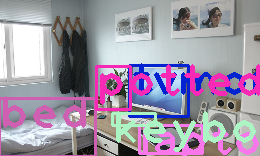

In [24]:

yolov3w='/content/drive/MyDrive/2023finalproject/yolov3.weights'
yolo3c='/content/drive/MyDrive/2023finalproject/yolov3.cfg'
# Load Yolo
net = cv2.dnn.readNet(yolov3w, yolo3c)
classes = []
coco='/content/drive/MyDrive/2023finalproject/coco.names'
with open(coco, "r") as f:
    classes = [line.strip() for line in f.readlines()]
layer_names = net.getLayerNames()
#[i[0]-1]
output_layers = [layer_names[i-1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))

room='/content/drive/MyDrive/2023finalproject/room_ser.jpg'
# test='/content/_Zh8kvud.jpg_large'
# Loading image
imgname='photo.jpg'
img = cv2.imread(room)
img = cv2.resize(img, None, fx=0.4, fy=0.4)
height, width, channels = img.shape

# Detecting objects
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)

# Showing informations on the screen
class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        #현재오류지점index 1256320 is out of bounds for axis 0 with size 27
        if confidence > 0.5:
            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

font = cv2.FONT_HERSHEY_PLAIN
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        color = colors[i]
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, label, (x, y + 30), font, 3, color, 3)
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [25]:
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

24/24 [==============================] - 3s 123ms/step - loss: 0.6517 - accuracy: 0.8051
정확도 : 0.8051


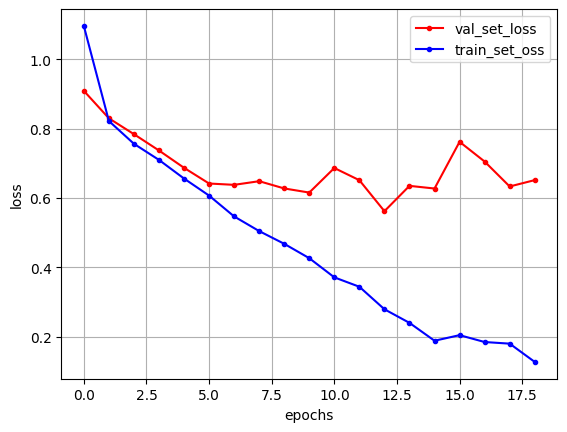

In [26]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()